In [28]:
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import string
import matplotlib.pyplot as plt
%matplotlib inline




sentences = []
with open('randgen.txt') as f:
    for line in f:
        l = re.sub(r'[^\w\s\d+]','',line).lower().strip('\n')
        sentences.append(l)
print("Size of dataset: ", len(sentences))


Size of dataset:  1360


In [31]:
# Basic RNN
def make_batch():
    input_batch = []
    target_batch = []

    for sen in sentences:
        word = sen.split()  # space tokenizer
        input = [word_dict[n] for n in word[:-1]]  # create (1~n-1) as input
        target = word_dict[word[-1]]  # create (n) as target, We usually call this 'casual language model'

        input_batch.append(np.eye(n_class)[input])
        target_batch.append(target)

    return input_batch, target_batch

class TextRNN(nn.Module):
    def __init__(self):
        super(TextRNN, self).__init__()
        self.rnn = nn.RNN(input_size=n_class, hidden_size=n_hidden)
        self.W = nn.Linear(n_hidden, n_class, bias=False)
        self.b = nn.Parameter(torch.ones([n_class]))

    def forward(self, hidden, X):
        X = X.transpose(0, 1) # X : [n_step, batch_size, n_class]
        outputs, hidden = self.rnn(X, hidden)
        # outputs : [n_step, batch_size, num_directions(=1) * n_hidden]
        # hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        outputs = outputs[-1] # [batch_size, num_directions(=1) * n_hidden]
        model = self.W(outputs) + self.b # model : [batch_size, n_class]
        return model

if __name__ == '__main__':
    n_step = 3 # number of cells(= number of Step)
    n_hidden = 5 # number of hidden units in one cell

    # sentences = ["acting is key", "acting is soul", "acting is mysterious", "acting is sport", "we love acting", "callen is handsome"]
    

    word_list = " ".join(sentences).split()
    word_list = list(set(word_list))
    word_dict = {w: i for i, w in enumerate(word_list)}
    number_dict = {i: w for i, w in enumerate(word_list)}
    n_class = len(word_dict)
    batch_size = len(sentences)

    model = TextRNN()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    input_batch, target_batch = make_batch()
    input_batch = torch.FloatTensor(input_batch)
    target_batch = torch.LongTensor(target_batch)
    loss_list = []

    # Training
    for epoch in range(70000):
        optimizer.zero_grad()

        # hidden : [num_layers * num_directions, batch, hidden_size]
        hidden = torch.zeros(1, batch_size, n_hidden)
        # input_batch : [batch_size, n_step, n_class]
        output = model(hidden, input_batch)

        # output : [batch_size, n_class], target_batch : [batch_size] (LongTensor, not one-hot)
        loss = criterion(output, target_batch)
        loss_list.append(loss)
        if (epoch + 1) % 1000 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()

    # input = [sen.split()[:2] for sen in sentences]

    # Predict
    hidden = torch.zeros(1, batch_size, n_hidden)
    predict = model(hidden, input_batch).data.max(1, keepdim=True)[1]
    #print([sen.split()[:2] for sen in sentences], '->', [number_dict[n.item()] for n in predict.squeeze()])
    sen_list = [sen.split()[:3] for sen in sentences]
    predicted_list = [number_dict[n.item()] for n in predict.squeeze()]

Epoch: 1000 cost = 4.227792
Epoch: 2000 cost = 3.348514
Epoch: 3000 cost = 2.869174
Epoch: 4000 cost = 2.486739
Epoch: 5000 cost = 2.160369
Epoch: 6000 cost = 1.903823
Epoch: 7000 cost = 1.698434
Epoch: 8000 cost = 1.520697
Epoch: 9000 cost = 1.366377
Epoch: 10000 cost = 1.227264
Epoch: 11000 cost = 1.105499
Epoch: 12000 cost = 1.001815
Epoch: 13000 cost = 0.905773
Epoch: 14000 cost = 0.818133
Epoch: 15000 cost = 0.737463
Epoch: 16000 cost = 0.667067
Epoch: 17000 cost = 0.605742
Epoch: 18000 cost = 0.545531
Epoch: 19000 cost = 0.491571
Epoch: 20000 cost = 0.439632
Epoch: 21000 cost = 0.398084
Epoch: 22000 cost = 0.364129
Epoch: 23000 cost = 0.332998
Epoch: 24000 cost = 0.304976
Epoch: 25000 cost = 0.280281
Epoch: 26000 cost = 0.255451
Epoch: 27000 cost = 0.235141
Epoch: 28000 cost = 0.216419
Epoch: 29000 cost = 0.201500
Epoch: 30000 cost = 0.189369
Epoch: 31000 cost = 0.177843
Epoch: 32000 cost = 0.167002
Epoch: 33000 cost = 0.157381
Epoch: 34000 cost = 0.147769
Epoch: 35000 cost = 0.1

In [32]:
out = []
count = 0
for i in range(len(sen_list)):
    strin = sen_list[i][0]+" "+sen_list[i][1]+" "+sen_list[i][2]+" "+predicted_list[i]
    out.append(strin)
    if(strin == sentences[i]):
        count+=1
print('acc: ', count / len(sen_list))

acc:  0.9536764705882353


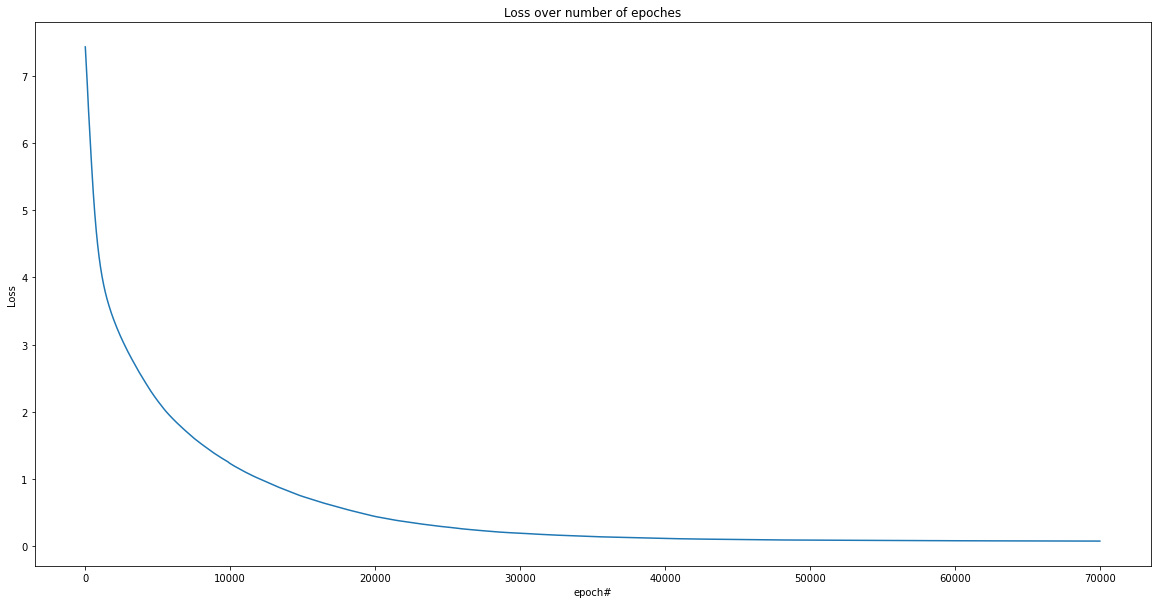

In [33]:
plt.figure(figsize=(20,10))
plt.plot(range(len(loss_list)), loss_list)
plt.title("Loss over number of epoches")
plt.xlabel('epoch#')
plt.ylabel('Loss')
plt.show()